Group and sum by metaprogram problem solved with: https://stackoverflow.com/questions/39650749/group-by-sparse-matrix-in-scipy-and-return-a-matrix

#### Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_directory = '/n/scratch/users/s/sad167/EPN/Xenium/'
directory = base_directory + 'analysis/all_Xenium_runs/neighborhood/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# import metadata
metadata = pd.read_excel(base_directory+'SampleIdentifier.xlsx')

# extract sample name and path to raw data
SampleName = (metadata['SampleID'] + '_' + metadata['SampleName']).tolist()

RawDataPath = metadata['RawDataPath'].tolist()

# color palette
metaprogram_names = ["Cycling", "Neuroepithelial-like", "Radial glia-like", 
                                       "Neuronal-like" ,"Ependymal-like", "Mesenchymal", "Unassigned", 
                                       "Immune", "Vascular", "Oligodendrocytes"]

metaprogram_colors = ["#4d4d4d","#F99E93FF","#9E5E9BFF",
                                '#0F4F8B',"#ACD39EFF","#96410EFF",'#cccccc', 
                                '#00c5cd',  '#cd3278',  '#cd3278', '#000000FF']

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

anndata_list = []
for i in range(len(SampleName)):
    adata = sc.read_10x_h5(filename = base_directory + 'data/raw_data/' + RawDataPath[i]+'/cell_feature_matrix.h5')
    df = pd.read_csv(base_directory + 'data/raw_data/' + RawDataPath[i]+'/cells.csv.gz')

    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')
    
    # read metadata with annotations
    anno = pd.read_csv(base_directory + 'analysis/all_Xenium_runs/data/cell_ID_' + SampleName[i] + '.csv', index_col = 0)

    # Replace values in the "group" column
    anno['group'].replace({'Endothelial': 'Vascular', 'VLMCs': 'Vascular',  'Myeloid': 'Immune',  'T-cell': 'Immune',  'Microglia': 'Immune'}, inplace=True)

    if 'X' in anno.columns:
        anno.index = anno['X']
    
    adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['group']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = SampleName[i]

    # Add the color information to the AnnData object
    adata.uns['Metaprogram_colors'] = metaprogram_to_color
    
    anndata_list.append(adata)
    
    print(SampleName[i])

adata = sc.concat(anndata_list) 


STEPN-17_0010652-Region_4
STEPN-12_0010575-Region_1
STEPN-12_0010575-Region_2
STEPN-12_0010575-Region_3
STEPN-06_0010619-Region_1
STEPN-06_0010619-Region_2
STEPN-06_0010619-Region_3
STEPN-10_0010619-Region_4
STEPN-10_0010619-Region_5
STEPN-19_0010501-Region_1
STEPN-19_0010501-Region_2
STEPN-14_0010814-Region_1
STEPN-14_0010814-Region_2
STEPN-18_0010498-Region_1
STEPN-16_0010775-Region_1
STEPN-01_0010540-Region_1
STEPN-01_0010540-Region_2
STEPN-01_0010540-Region_3
STEPN-12_0010540-Region_4
STEPN-06_0010553-Region_1
STEPN-06_0010553-Region_2
STEPN-15_0010553-Region_3
STEPN-10_0010553-Region_4


In [4]:
# Subset to remove "Unassigned" program and oligodendrocytes (too little cell number)
adata = adata[~adata.obs['Metaprogram'].isin(['Unassigned', 'Oligodendrocytes'])]

# Create a color palette for each unique Metaprogram
metaprogram_names = ["Cycling", "Neuroepithelial-like", "Radial glia-like", 
                                       "Neuronal-like" ,"Ependymal-like", "Mesenchymal",
                                       "Immune", "Vascular"]

metaprogram_colors = ["#4d4d4d","#F99E93FF","#9E5E9BFF",
                                '#0F4F8B',"#ACD39EFF","#96410EFF",
                                '#00c5cd',  '#cd3278',  '#cd3278']


metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

ad = adata

In [5]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
    print(sample)

STEPN-17_0010652-Region_4
STEPN-12_0010575-Region_1
STEPN-12_0010575-Region_2
STEPN-12_0010575-Region_3
STEPN-06_0010619-Region_1
STEPN-06_0010619-Region_2
STEPN-06_0010619-Region_3
STEPN-10_0010619-Region_4
STEPN-10_0010619-Region_5
STEPN-19_0010501-Region_1
STEPN-19_0010501-Region_2
STEPN-14_0010814-Region_1
STEPN-14_0010814-Region_2
STEPN-18_0010498-Region_1
STEPN-16_0010775-Region_1
STEPN-01_0010540-Region_1
STEPN-01_0010540-Region_2
STEPN-01_0010540-Region_3
STEPN-12_0010540-Region_4
STEPN-06_0010553-Region_1
STEPN-06_0010553-Region_2
STEPN-15_0010553-Region_3
STEPN-10_0010553-Region_4


#### Compute centrality scores per sample

In [7]:
centralityScore_list = []
for i in range(len(anndata_list)):
    anndata_list[i].obsm["spatial"] = np.array([anndata_list[i].obs.x_centroid*0.325, anndata_list[i].obs.y_centroid*0.325]).transpose().astype('float64')
    anndata_list[i].X = np.nan_to_num(anndata_list[i].X)
    anndata_list[i] = anndata_list[i][anndata_list[i].obs['counts'] > 6]
    anndata_list[i].raw = anndata_list[i]
    
    sq.gr.spatial_neighbors(anndata_list[i], coord_type = "generic", delaunay = True)
    sq.gr.centrality_scores(anndata_list[i], cluster_key = "Metaprogram")

    dt = anndata_list[i].uns['Metaprogram_centrality_scores']
    dt['Metaprogram'] = dt.index
    dt['Sample'] = SampleName[i]
    
    centralityScore_list.append(dt)
    print(SampleName[i])

STEPN-17_0010652-Region_4
STEPN-12_0010575-Region_1
STEPN-12_0010575-Region_2
STEPN-12_0010575-Region_3
STEPN-06_0010619-Region_1
STEPN-06_0010619-Region_2
STEPN-06_0010619-Region_3
STEPN-10_0010619-Region_4
STEPN-10_0010619-Region_5
STEPN-19_0010501-Region_1
STEPN-19_0010501-Region_2
STEPN-14_0010814-Region_1
STEPN-14_0010814-Region_2
STEPN-18_0010498-Region_1
STEPN-16_0010775-Region_1
STEPN-01_0010540-Region_1
STEPN-01_0010540-Region_2
STEPN-01_0010540-Region_3
STEPN-12_0010540-Region_4
STEPN-06_0010553-Region_1
STEPN-06_0010553-Region_2
STEPN-15_0010553-Region_3
STEPN-10_0010553-Region_4


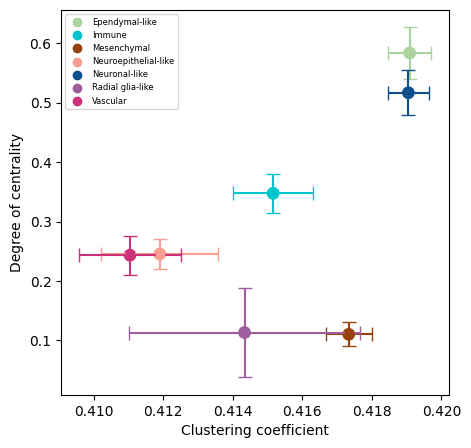

In [8]:
## Concatenate scores
dt = pd.concat(centralityScore_list)
## Calculated average and SEM
dt = dt.groupby(['Metaprogram'], as_index=False).agg({
    'degree_centrality': ['mean', 'sem'],
    'average_clustering': ['mean', 'sem'],
    'closeness_centrality': ['mean', 'sem']
})

dt.columns = ['Metaprogram', 
              'degree_centrality_mean', 'degree_centrality_sem', 
              'average_clustering_mean', 'average_clustering_sem', 
              'closeness_centrality_mean', 'closeness_centrality_sem']

## Scatter plot with error bars
plt.figure(figsize=(5, 5))
pt = sns.scatterplot(data=dt, x="average_clustering_mean", y="degree_centrality_mean", hue="Metaprogram", 
                     palette=metaprogram_to_color, legend = True, s = 100)
for i, row in dt.iterrows():
    plt.errorbar(x=row['average_clustering_mean'], y=row['degree_centrality_mean'], 
                  xerr=row['average_clustering_sem'], yerr=row['degree_centrality_sem'], 
                 fmt='o', capsize=5, color=metaprogram_to_color[row['Metaprogram']])


pt.set(xlabel = 'Clustering coefficient', ylabel = 'Degree of centrality')
pt.legend(fontsize = 6)
plt.savefig(directory+f"/1_centrality_scores_averages.pdf")
plt.show()

In [11]:
# Calculate neighborhood
nhood_list = []
for i in range(len(anndata_list)):
    sq.gr.nhood_enrichment(anndata_list[i], cluster_key = "Metaprogram", seed = 1234)
    
    df = pd.DataFrame(anndata_list[i].uns['Metaprogram_nhood_enrichment']['zscore'])
    df.index = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df.columns = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df['Programs'] = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df = pd.melt(df, id_vars='Programs')
    
    nhood_list.append(df)


  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

In [12]:
## Averaging metrics
dt = pd.concat(nhood_list)
dt = dt.groupby(['Programs', 'variable'], as_index=False).agg({'value': 'mean'})
dt = dt.pivot(index='Programs', columns='variable')['value']
dt.to_csv(directory+f'2_neighborhood.csv')